In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt #2d vis
from mpl_toolkits.mplot3d import axes3d #3d vis
import torch
import json
import math

In [2]:
arg_dataset = 'h36m'
arg_keypoints = 'gt'

## data loading

In [3]:
fn_2d = 'data/data_2d_' + arg_dataset + '_' + arg_keypoints + '.npz'
fn_3d = 'data/data_3d_' + arg_dataset + '.npz'

print(fn_2d)
print(fn_3d)

data/data_2d_h36m_gt.npz
data/data_3d_h36m.npz


In [4]:
keypoints = np.load(fn_2d, allow_pickle=True)
dataset_2d = keypoints['positions_2d'].item()

from common.h36m_dataset import Human36mDataset
dataset_3d = Human36mDataset(fn_3d)

## checking data format|

- ground truth 2D data format
```
{ 'subject',  'action', '2d_17keypoints'}
```

In [5]:
#subject list
dataset_2d.keys()

dict_keys(['S1', 'S5', 'S6', 'S7', 'S8', 'S9', 'S11'])

In [6]:
#action list
dataset_2d['S1'].keys()

dict_keys(['Discussion 1', 'Purchases 1', 'Directions 1', 'WalkTogether 1', 'Discussion', 'Eating', 'Photo', 'Greeting', 'Walking 1', 'WalkTogether', 'Waiting 1', 'Smoking', 'Sitting 1', 'Photo 1', 'SittingDown', 'WalkDog 1', 'Walking', 'Waiting', 'Directions', 'Purchases', 'Phoning', 'Posing 1', 'Greeting 1', 'Sitting 2', 'WalkDog', 'Phoning 1', 'SittingDown 2', 'Posing', 'Smoking 1', 'Eating 2'])

- 3D data format 
```
{ 'subject', 'actions', '3d_17keypoints', '4_camera_parameters'}
```

In [7]:
#subject list
dataset_3d.subjects()

dict_keys(['S1', 'S5', 'S6', 'S7', 'S8', 'S9', 'S11'])

In [8]:
#action list
dataset_3d['S1'].keys(), len(dataset_3d['S1'].keys())

(dict_keys(['Discussion 1', 'Purchases 1', 'Directions 1', 'WalkTogether 1', 'Discussion', 'Eating', 'Photo', 'Greeting', 'Walking 1', 'WalkTogether', 'Waiting 1', 'Smoking', 'Sitting 1', 'Photo 1', 'SittingDown', 'WalkDog 1', 'Walking', 'Waiting', 'Directions', 'Purchases', 'Phoning', 'Posing 1', 'Greeting 1', 'Sitting 2', 'WalkDog', 'Phoning 1', 'SittingDown 2', 'Posing', 'Smoking 1', 'Eating 2']),
 30)

In [9]:
#list of information in 3d dataset
dataset_3d['S1']['Discussion 1'].keys()

dict_keys(['positions', 'cameras'])

In [10]:
#checking the shape of 3d dataset
dataset_3d['S1']['Discussion 1']['positions'].shape

(3805, 17, 3)

## Get information according to subject, action, 2d/3d

For 2d image views
```
index - camera id
0 - 54138969
1 - 55011271
2 - 58860488
3 - 60457274
```

In [11]:
camera_id = [54138969, 55011271, 58860488, 60457274]

In [12]:
# inserting the information
subject = 'S1'
action = 'Smoking'
view_2d = 1 #0~3
frame_idx = 100

- 2D data exploration
    - get video frame
    - draw ground truth 2d skeleton

In [13]:
#getting the matching video information
vd_data_dir = './data/h36m_dataset/{}/Video/{}.{}.mp4'.format(subject, action, camera_id[view_2d])
vd_data_dir

'./h36m_dataset/S1/Video/Smoking.55011271.mp4'

In [14]:
video = cv2.VideoCapture(vd_data_dir)

In [15]:
timestamp = frame_idx*20

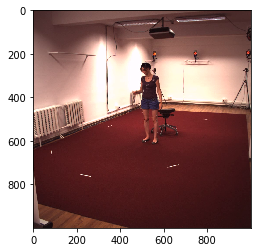

In [16]:
video.set(cv2.CAP_PROP_POS_MSEC, timestamp)
frame_exists, image = video.read()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [17]:
#joint connection of h36m dataset
bones = [[0,1],[1,2],[2,3],[0,4],[4,5],[5,6],
           [0,7],[7,8],[8,9],[9,10],[8,11],[11,12],[12,13],
           [8,14],[14,15],[15,16]]

In [18]:
data_2d = dataset_2d[subject][action][view_2d][frame_idx]
data_2d

array([[535.0685 , 405.442  ],
       [508.76837, 402.15662],
       [517.87244, 494.47464],
       [526.0878 , 582.91833],
       [561.8783 , 408.81018],
       [561.41046, 503.70883],
       [569.5875 , 593.7366 ],
       [536.3011 , 354.74075],
       [535.01935, 298.49417],
       [516.20953, 282.99423],
       [519.5963 , 258.77893],
       [562.45953, 313.1653 ],
       [582.39   , 371.5369 ],
       [588.30237, 424.5852 ],
       [511.18256, 312.62222],
       [495.93848, 368.19894],
       [473.9501 , 378.74057]], dtype=float32)

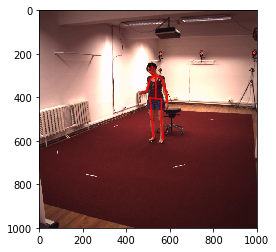

In [19]:
#draw ground truth 2d skeleton on the matching video frame
plt.imshow(image)

plt.xlim([0,1000])
plt.ylim([1000,0])

for bone in bones:
    s = bone[0]
    e = bone[1]

    x = [data_2d[s][0], data_2d[e][0]]
    y = [data_2d[s][1], data_2d[e][1]]
    plt.plot(x,y, c='r')
    
plt.show()

- 3d data exploration
    - draw 3d skeleton

In [20]:
data_3d = dataset_3d[subject][action]['positions'][frame_idx]
data_3d

array([[-0.0783266 , -0.16242   ,  0.940099  ],
       [-0.21088575, -0.156166  ,  0.948117  ],
       [-0.17553662, -0.126362  ,  0.5076425 ],
       [-0.15521166, -0.06389793,  0.05821105],
       [ 0.05423278, -0.168674  ,  0.932081  ],
       [ 0.05533141, -0.16319399,  0.48922184],
       [ 0.0808828 , -0.10095847,  0.04002532],
       [-0.08963297, -0.12000001,  1.1694095 ],
       [-0.0962164 , -0.12311961,  1.4263839 ],
       [-0.15867679, -0.19890411,  1.4972999 ],
       [-0.15767922, -0.16035117,  1.6056429 ],
       [ 0.04048261, -0.13393563,  1.3630773 ],
       [ 0.13228881, -0.11496272,  1.1004231 ],
       [ 0.19209294, -0.2017861 ,  0.87182975],
       [-0.22655031, -0.08904244,  1.3581028 ],
       [-0.31319866, -0.06435531,  1.0941637 ],
       [-0.31727594, -0.3146815 ,  1.0679433 ]], dtype=float32)

In [21]:
# for interactive 3d figure
# %matplotlib notebook

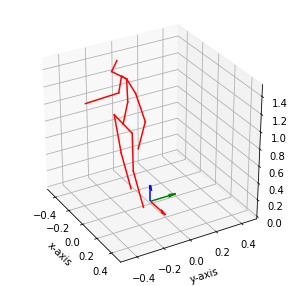

In [22]:
# draw 3d skeleton
fig = plt.figure(figsize=(5,5)) #figsize=(20,20)
ax = fig.add_subplot(projection='3d')
ax.set_aspect('auto') ##############
ax.view_init(30, -30)

ax.set_zlim(0, 1.5)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')

ax.quiver(0,0,0,0.2,0,0, color='r') #x-axis
ax.quiver(0,0,0,0,0.2,0, color='g') #y-axis
ax.quiver(0,0,0,0,0,0.2, color='b') #z-axis

for bone in bones:
    s = bone[0]
    e = bone[1]

    col = 'red'

    x = [(data_3d[s][0]), (data_3d[e][0])]
    y = [(data_3d[s][1]), (data_3d[e][1])]
    z = [(data_3d[s][2]), (data_3d[e][2])]

    ax.plot(x, y, z, c = col)


plt.show()

## Calculation of 2d projection

Camera extrinsic parameter (Rotation matrix and translation vector)
$\begin{bmatrix}x\\y\\z\\1\end{bmatrix} = \begin{bmatrix} r_{11} & r_{12} & r_{13} & t_1\\ r_{21} & r_{22} & r_{23}&t_2\\
r_{31} & r_{32} & r_{33}&t_3\\ 0 & 0 & 0 & 1 \end{bmatrix} \begin{bmatrix}x_0\\y_0\\z_0\\1\end{bmatrix}\\
(where,\ r_{ij}\ is\ rotation\ matrix\ values, and\ t_i\ is\ translation\ vectors)
$

Camera intrinsic parameter (Projective transform)
$
x' = x/z\\
y' = y/z\\
  \\
x_{screen} = f_x * x' + c_x\\
y_{screen} = f_y * y' + c_y\\
(where,\ f_x\ and\ f_y\ are\ focal\ length, c_x\ and\ c_y\ are\ center\ of\ coordinates)
$

#### getting camera parameter information

In [23]:
#camera parameter from h36m github https://github.com/karfly/human36m-camera-parameters
fn_cam = './data/camera-parameters.json'

In [24]:
f = open(fn_cam)
camera_parameter = json.load(f)

In [25]:
rotation_matrix = camera_parameter['extrinsics'][subject][str(camera_id[view_2d])]['R']
rotation_matrix

[[0.9281683400814921, 0.3721538354721445, 0.002248380248018696],
 [0.08166409428175585, -0.1977722953267526, -0.976840363061605],
 [-0.3630902204349604, 0.9068559102440475, -0.21395758897485287]]

In [26]:
translation_vector = camera_parameter['extrinsics'][subject][str(camera_id[view_2d])]['t']
translation_vector

[[251.42516271750836], [420.9422103702068], [5588.195881837821]]

In [27]:
cam_matrix = camera_parameter['intrinsics'][str(camera_id[view_2d])]['calibration_matrix']
cam_matrix

[[1149.67569986785, 0.0, 508.848621645943],
 [0.0, 1147.59161666764, 508.064917088557],
 [0.0, 0.0, 1.0]]

#### step-by-step calculation process

In [28]:
# data frame to work on
data_3d = dataset_3d[subject][action]['positions'][frame_idx]
data_3d, data_3d.shape

(array([[-0.0783266 , -0.16242   ,  0.940099  ],
        [-0.21088575, -0.156166  ,  0.948117  ],
        [-0.17553662, -0.126362  ,  0.5076425 ],
        [-0.15521166, -0.06389793,  0.05821105],
        [ 0.05423278, -0.168674  ,  0.932081  ],
        [ 0.05533141, -0.16319399,  0.48922184],
        [ 0.0808828 , -0.10095847,  0.04002532],
        [-0.08963297, -0.12000001,  1.1694095 ],
        [-0.0962164 , -0.12311961,  1.4263839 ],
        [-0.15867679, -0.19890411,  1.4972999 ],
        [-0.15767922, -0.16035117,  1.6056429 ],
        [ 0.04048261, -0.13393563,  1.3630773 ],
        [ 0.13228881, -0.11496272,  1.1004231 ],
        [ 0.19209294, -0.2017861 ,  0.87182975],
        [-0.22655031, -0.08904244,  1.3581028 ],
        [-0.31319866, -0.06435531,  1.0941637 ],
        [-0.31727594, -0.3146815 ,  1.0679433 ]], dtype=float32),
 (17, 3))

##### Camera extrinsic parameter (rotation matrix + translation vector calculation)

In [30]:
rotation_matrix = np.array(rotation_matrix)
rotation_matrix_homo = np.hstack((rotation_matrix, translation_vector))
rotation_matrix_homo = np.vstack([rotation_matrix_homo, [0.0, 0.0, 0.0, 1.0]])
rotation_matrix_homo.shape, rotation_matrix_homo

((4, 4),
 array([[ 9.28168340e-01,  3.72153835e-01,  2.24838025e-03,
          2.51425163e-01],
        [ 8.16640943e-02, -1.97772295e-01, -9.76840363e-01,
          4.20942210e-01],
        [-3.63090220e-01,  9.06855910e-01, -2.13957589e-01,
          5.58819588e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]))

In [31]:
data_3d = data_3d.tolist()

In [32]:
for i in range(len(data_3d)):
    data_3d[i].append(1.0)
    
data_3d = np.array(data_3d)

In [33]:
#camera extrinsic matrix calculation
for i in range(len(data_3d)):
    value = np.dot(rotation_matrix, data_3d[i].transpose())
#     print(value)
    if i == 0:
        proj = value
    else:
        proj = np.vstack((proj, value))

In [34]:
proj.shape

(17, 3)

In [35]:
#allocating camera intrinsic parameter values
fx = cam_matrix[0][0]
cx = cam_matrix[0][2]
fy = cam_matrix[1][1]
cy = cam_matrix[1][2]
fx, fy, cx, cy

(1149.67569986785, 1147.59161666764, 508.848621645943, 508.064917088557)

In [36]:
#camera intrinsic matrix calculation
proj_2d = []
for i in range(17):
    a_pt_3d = proj[i]
#     print(a_pt_3d)
    xp = a_pt_3d[0] / a_pt_3d[2]
    yp = a_pt_3d[1] / a_pt_3d[2]
    
    u = fx*xp + cx
    v = fy*yp + cy
    proj_2d.append([u, v])
    
proj_2d = np.array(proj_2d)

##### checking the projected 2d data
##### reprojection error calculation

In [37]:
proj_2d

array([[535.12197093, 405.32179126],
       [508.78414795, 402.03640486],
       [517.8730272 , 494.47499944],
       [526.11466589, 583.01279594],
       [561.98584697, 408.67279431],
       [561.43922515, 503.71336937],
       [569.71915786, 593.92671575],
       [536.42343699, 354.30909129],
       [535.23882899, 297.35842018],
       [516.33201215, 281.60534756],
       [519.77509317, 256.87446208],
       [562.81237297, 312.19496368],
       [582.6648705 , 371.14832819],
       [588.46847402, 424.46232883],
       [511.24910139, 311.72989185],
       [495.93398574, 367.8937873 ],
       [473.89684451, 378.49192958]])

In [38]:
data_2d

array([[535.0685 , 405.442  ],
       [508.76837, 402.15662],
       [517.87244, 494.47464],
       [526.0878 , 582.91833],
       [561.8783 , 408.81018],
       [561.41046, 503.70883],
       [569.5875 , 593.7366 ],
       [536.3011 , 354.74075],
       [535.01935, 298.49417],
       [516.20953, 282.99423],
       [519.5963 , 258.77893],
       [562.45953, 313.1653 ],
       [582.39   , 371.5369 ],
       [588.30237, 424.5852 ],
       [511.18256, 312.62222],
       [495.93848, 368.19894],
       [473.9501 , 378.74057]], dtype=float32)

In [39]:
diff = data_2d-proj_2d

In [40]:
#reprojection error
tot_error = 0
for i in range(len(data_2d)):
    error = math.sqrt(diff[i][0]**2 + diff[i][1]**2)
    tot_error += error

reproj_error = tot_error/len(data_2d)

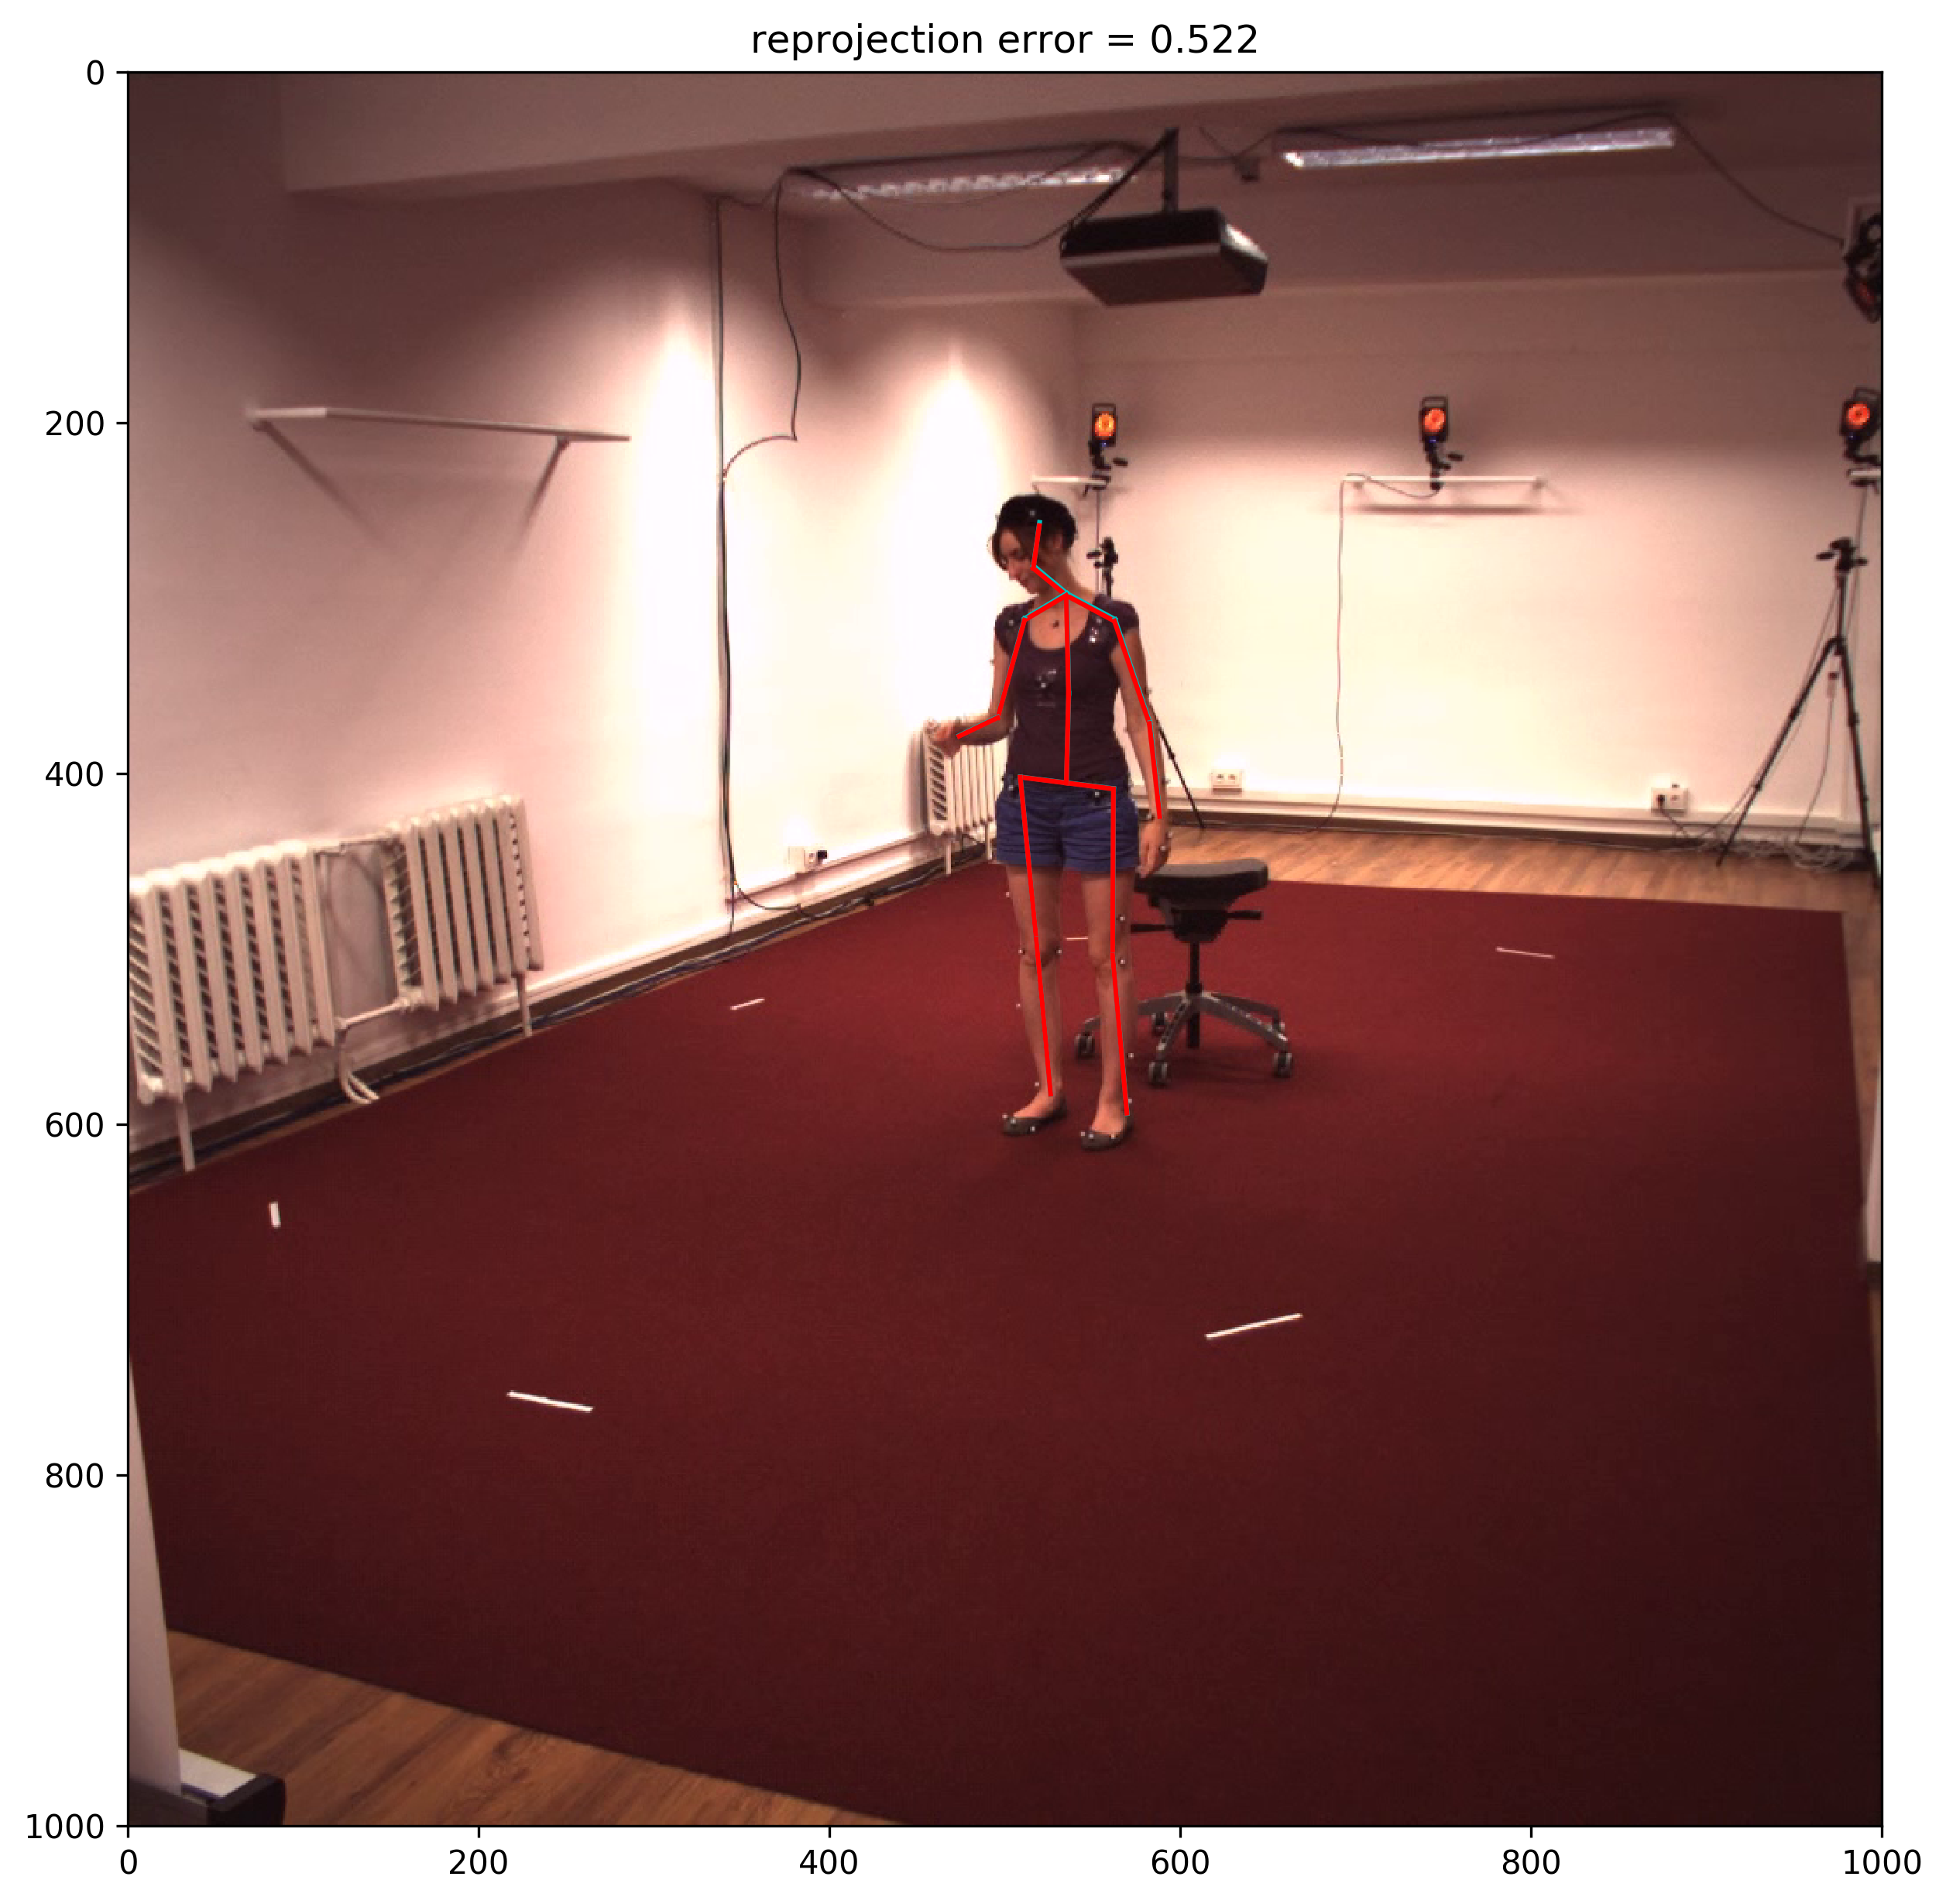

In [41]:
plt.figure(dpi = 300, figsize=(10,10))
plt.imshow(image)

plt.xlim([0,1000])
plt.ylim([1000,0])

for bone in bones:
    s = bone[0]
    e = bone[1]

    #projected 2d
    x = [proj_2d[s][0], proj_2d[e][0]]
    y = [proj_2d[s][1], proj_2d[e][1]]
    plt.plot(x,y, c='c')

    #original 2d
    x = [data_2d[s][0], data_2d[e][0]]
    y = [data_2d[s][1], data_2d[e][1]]
    plt.plot(x,y, c='r')
    
plt.title('reprojection error = {:.3f}'.format(reproj_error))
plt.show()

## Working on all frames of one video

In [42]:
rotation_matrix

[[0.9281683400814921,
  0.3721538354721445,
  0.002248380248018696,
  0.25142516271750837],
 [0.08166409428175585,
  -0.1977722953267526,
  -0.976840363061605,
  0.4209422103702068],
 [-0.3630902204349604,
  0.9068559102440475,
  -0.21395758897485287,
  5.58819588183782]]

In [43]:
data_list = dataset_3d[subject][action]['positions']
data_list.shape

(2478, 17, 3)

In [44]:
#getting the matching ground truth 2d dataset
gt_2d_list = dataset_2d[subject][action][view_2d]
gt_2d_list.shape

(2478, 17, 2)

In [45]:
# calculation of 2d projection points for all frames
proj_list = []
reproj_err = []
for frame in data_list:
    frame = frame.tolist()

    for i in range(len(frame)):
        frame[i].append(1.0)

    frame = np.array(frame)

    #camera extrinsic matrix calculation
    for i in range(len(frame)):
        value = np.dot(rotation_matrix, frame[i].transpose())
    #     print(value)
        if i == 0:
            proj = value
        else:
            proj = np.vstack((proj, value))

    #camera intrinsic matrix calculation
    proj_2d = []
    for i in range(17):
        a_pt_3d = proj[i]
    #     print(a_pt_3d)
        xp = a_pt_3d[0] / a_pt_3d[2]
        yp = a_pt_3d[1] / a_pt_3d[2]

        u = fx*xp + cx
        v = fy*yp + cy
        proj_2d.append([u, v])
    
    proj_list.append(proj_2d)
    
#calculation of reprojection error
for frame_no in range(len(gt_2d_list)):
    gt = np.array(gt_2d_list[frame_no])
    pj = np.array(proj_list[frame_no])
    
    diff = gt - pj
    
    tot_error = 0
    for i in range(len(data_2d)):
        error = math.sqrt(diff[i][0]**2 + diff[i][1]**2)
        tot_error += error

    err = tot_error/len(data_2d)
    
    reproj_err.append(err)

proj_list = np.array(proj_list)
reproj_err = np.array(reproj_err)

In [46]:
proj_list.shape, reproj_err.shape

((2478, 17, 2), (2478,))

In [47]:
# inserting the frame no. to visualize the projected 2d skeleton
frame_no = 100

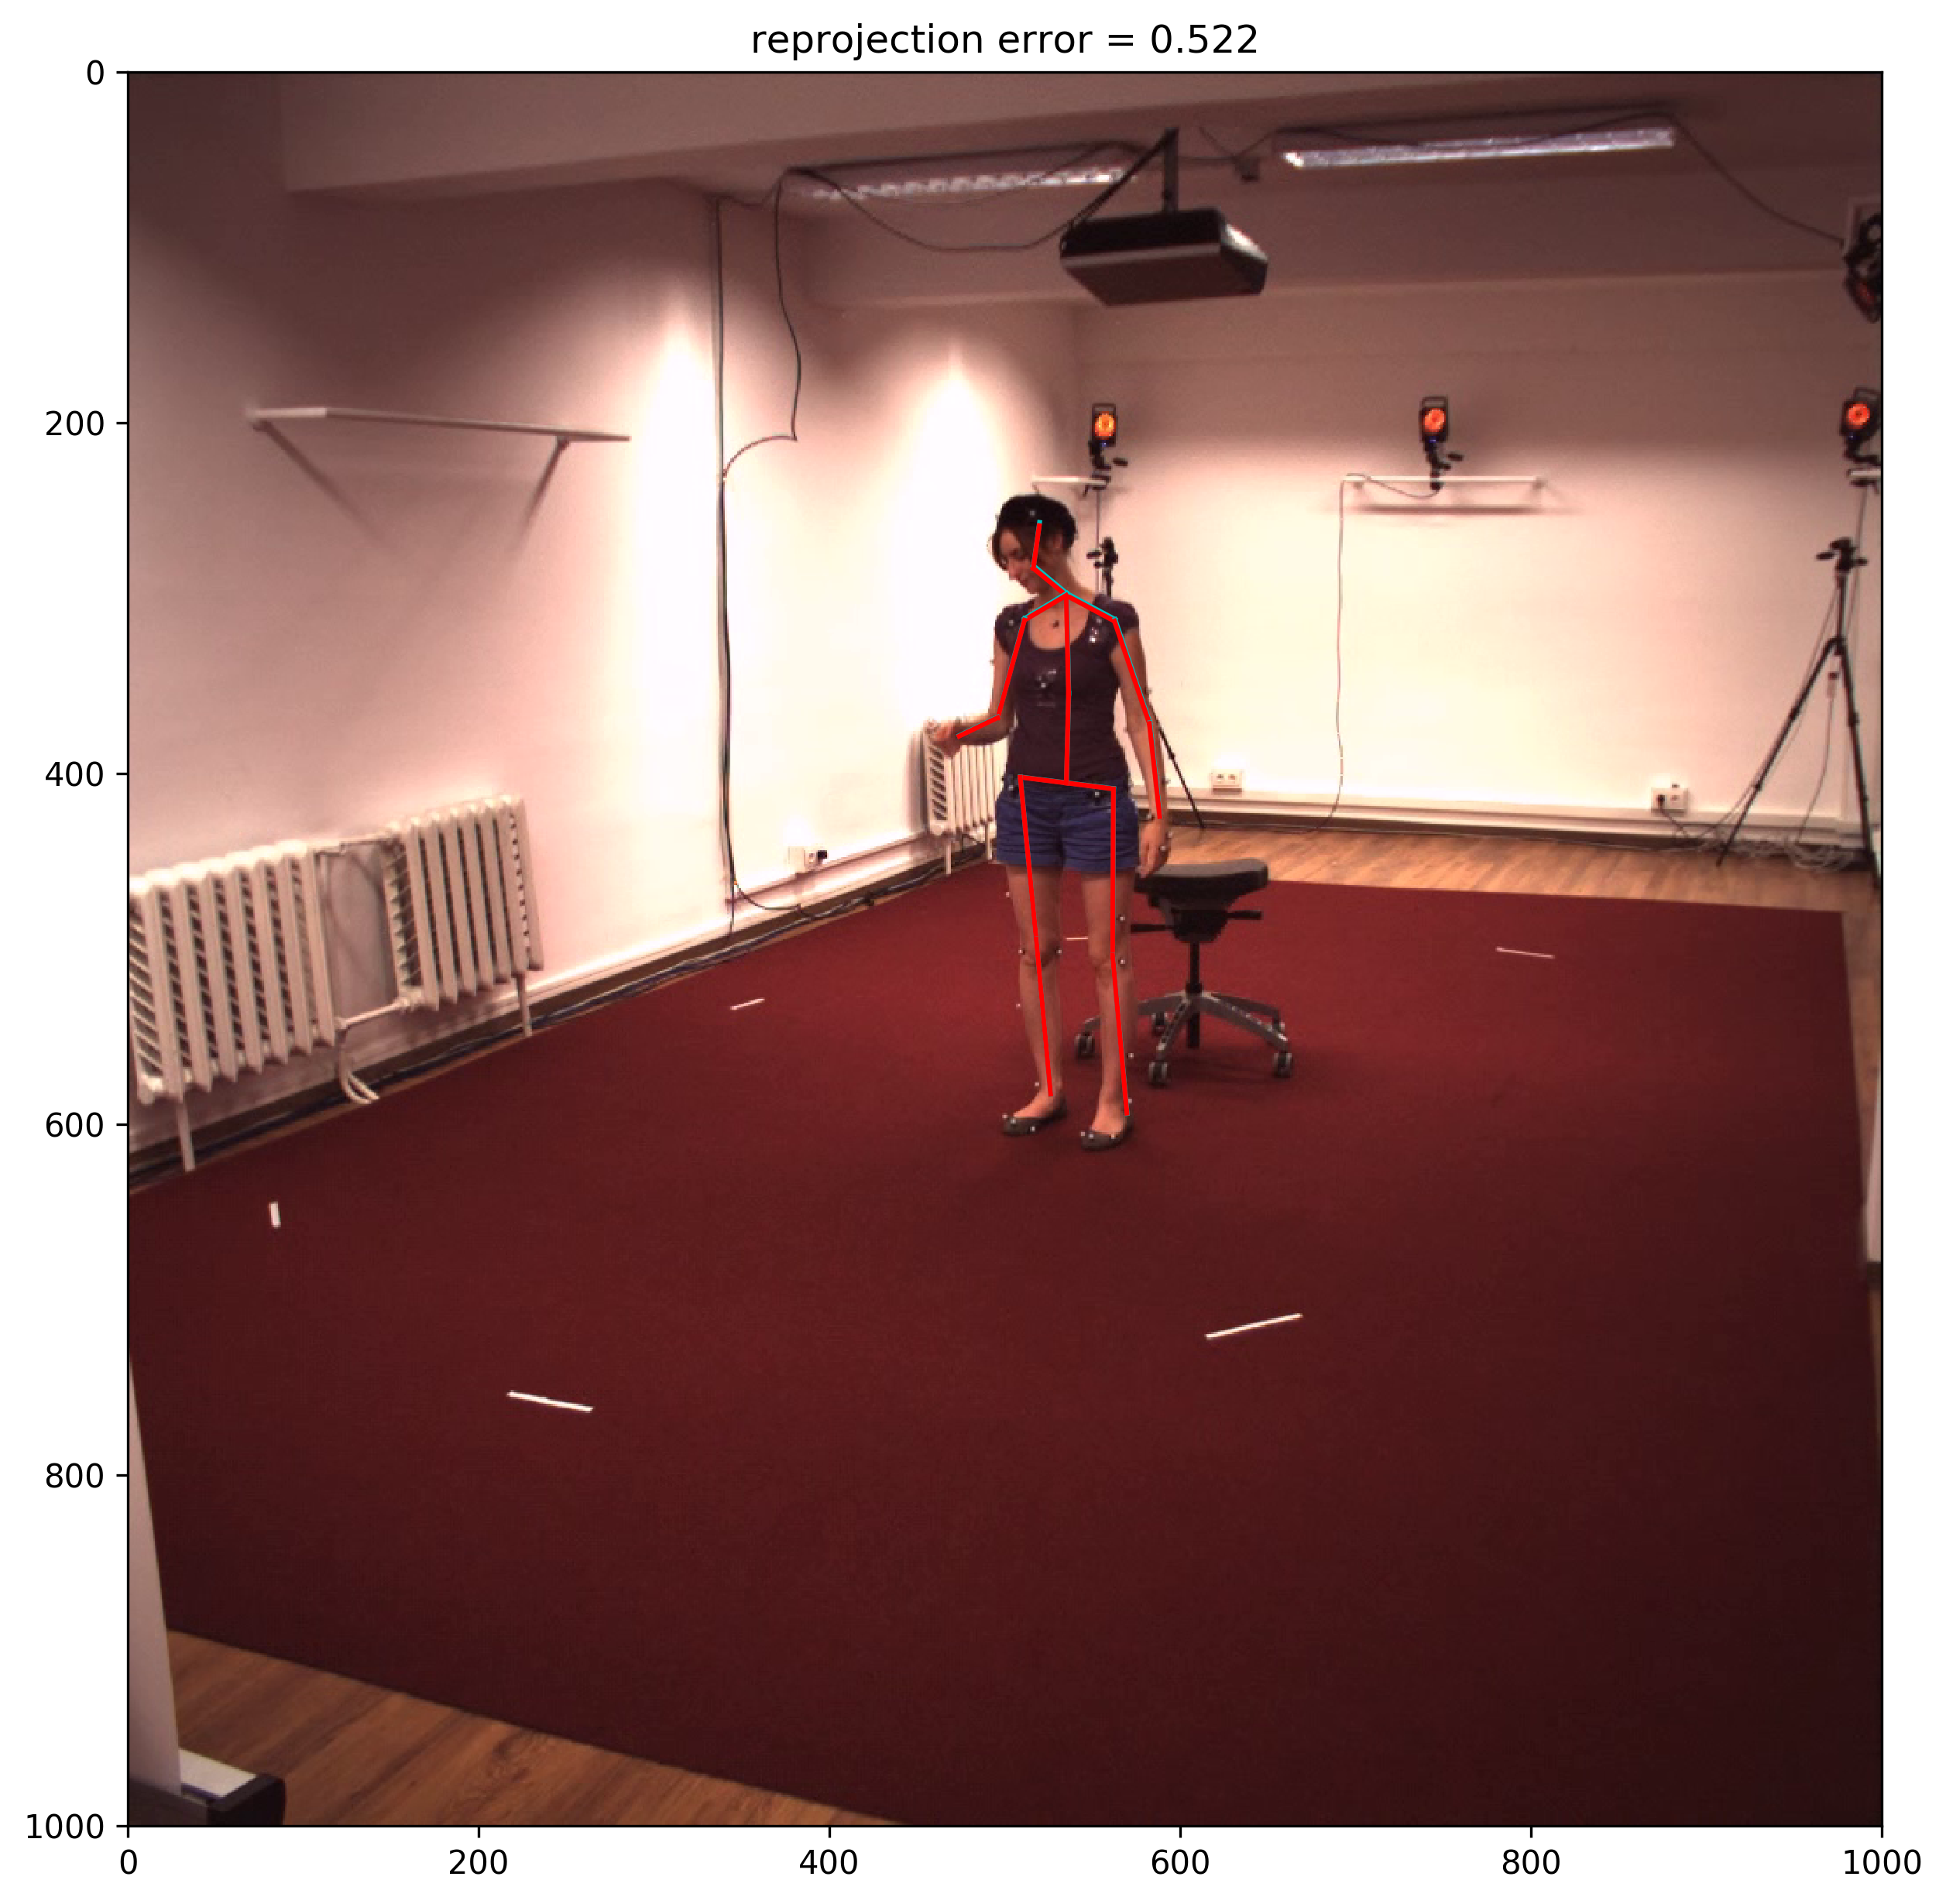

In [48]:
# visualizing projected and ground truth 2d skeleton of the frame no. selected
timestamp = frame_no*20
video.set(cv2.CAP_PROP_POS_MSEC, timestamp)
frame_exists, image = video.read()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(dpi = 300, figsize=(10,10))
plt.imshow(image)

plt.xlim([0,1000])
plt.ylim([1000,0])

for bone in bones:
    s = bone[0]
    e = bone[1]

    #projected 2d
    x = [proj_list[frame_no][s][0], proj_list[frame_no][e][0]]
    y = [proj_list[frame_no][s][1], proj_list[frame_no][e][1]]
    plt.plot(x,y, c='c')

    #ground truth 2d
    x = [gt_2d_list[frame_no][s][0], gt_2d_list[frame_no][e][0]]
    y = [gt_2d_list[frame_no][s][1], gt_2d_list[frame_no][e][1]]
    plt.plot(x,y, c='r')

plt.title('reprojection error = {:.3f}'.format(reproj_err[frame_no]))
plt.show()

##### Reprojection error

In [49]:
reproj_err.shape

(2478,)

Text(0, 0.5, 'error')

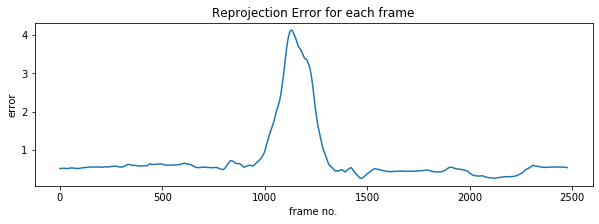

In [50]:
plt.figure(figsize=(10,3))
plt.plot(reproj_err)
plt.title('Reprojection Error for each frame')
plt.xlabel('frame no.')
plt.ylabel('error')

In [51]:
reproj_err.max()
for i in range(len(reproj_err)):
    if reproj_err[i]==reproj_err.max():
        frame_no = i
        print(i)

1130


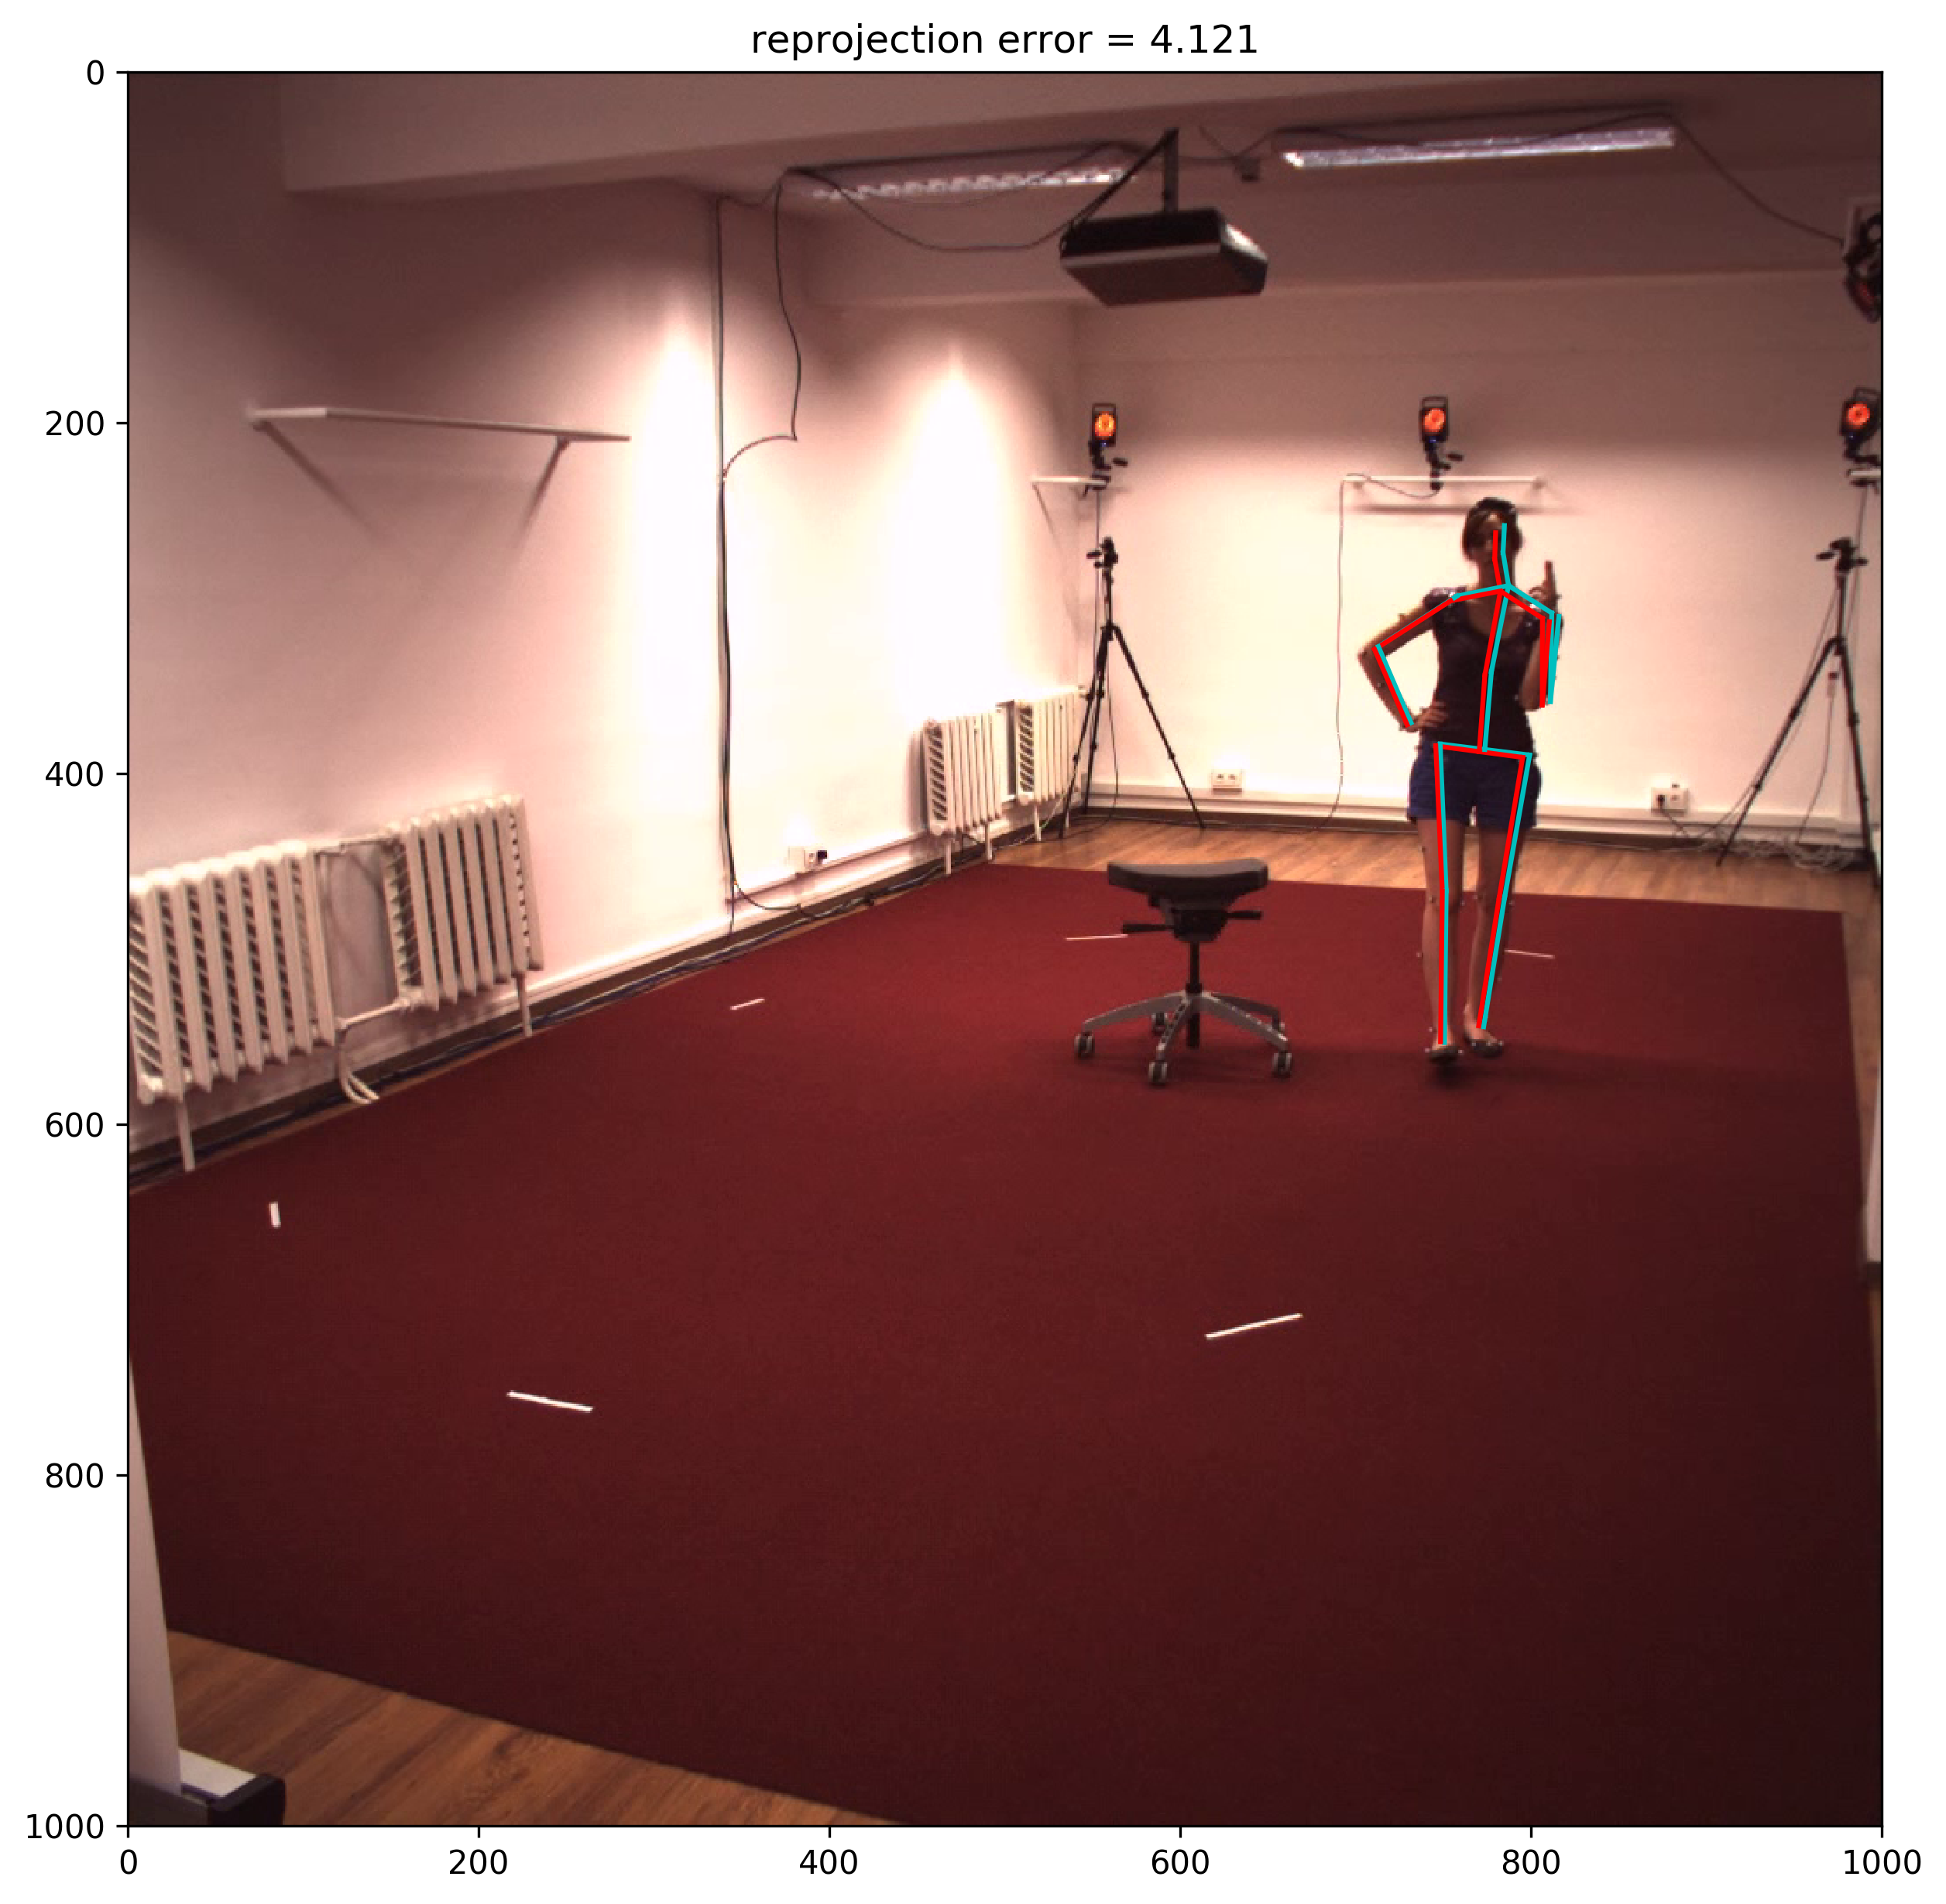

In [52]:
# visualizing projected and ground truth 2d skeleton 
# of the frame no. with the highest reprojeciton error
timestamp = frame_no*20
video.set(cv2.CAP_PROP_POS_MSEC, timestamp)
frame_exists, image = video.read()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(dpi = 300, figsize=(10,10))
plt.imshow(image)

plt.xlim([0,1000])
plt.ylim([1000,0])

for bone in bones:
    s = bone[0]
    e = bone[1]

    #projected 2d
    x = [proj_list[frame_no][s][0], proj_list[frame_no][e][0]]
    y = [proj_list[frame_no][s][1], proj_list[frame_no][e][1]]
    plt.plot(x,y, c='c')

    #ground truth 2d
    x = [gt_2d_list[frame_no][s][0], gt_2d_list[frame_no][e][0]]
    y = [gt_2d_list[frame_no][s][1], gt_2d_list[frame_no][e][1]]
    plt.plot(x,y, c='r')

plt.title('reprojection error = {:.3f}'.format(reproj_err[frame_no]))
plt.show()

##### saving the data into txt file

In [53]:
#check is all the data is in the same shape
gt_2d_list.shape, proj_list.shape, reproj_err.shape

((2478, 17, 2), (2478, 17, 2), (2478,))

In [54]:
#setting the txt file name
txt_file = './txt_file/{}_{}_{}.txt'.format(subject, action, camera_id[view_2d])
txt_file

'./h36m_dataset/txt_file/S1_Smoking_55011271.txt'

In [55]:
with open(txt_file, 'w') as f:
    for i in range(len(gt_2d_list)):
        f.write(str(i)+'\t')
        for j in range(len(gt_2d_list[i])):
            f.write(str(gt_2d_list[i][j][0]) + '\t')
            f.write(str(gt_2d_list[i][j][1]) + '\t')
        for j in range(len(proj_list[i])):
            f.write(str(proj_list[i][j][0]) + '\t')
            f.write(str(proj_list[i][j][1]) + '\t')
        f.write(str(reproj_err[i]) + '\t')
        f.write('\n')